Код с прошлого шага

In [20]:
import torch
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

class CSVDataset(Dataset):
    
    def __init__(self, file_path, target_column, 
                 numeric_features=None, 
                 categorical_features=None,
                 binary_features=None):
        # Загрузка данных
        self.df = pd.read_csv(file_path)
        
        # Проверка наличия колонок
        self._validate_columns(target_column, numeric_features, 
                             categorical_features, binary_features)
        
        # Сохранение параметров
        self.target_column = target_column
        self.numeric_features = numeric_features or []
        self.categorical_features = categorical_features or []
        self.binary_features = binary_features or []
        
        # Предобработка данных
        self.preprocessor = self._create_preprocessor()
        self.X = self._preprocess_features()
        self.y = self._get_target()
        
    def _validate_columns(self, target_column, numeric_features, 
                         categorical_features, binary_features):
        #Проверка колонок
        all_columns = (numeric_features or []) + \
                     (categorical_features or []) + \
                     (binary_features or []) + \
                     [target_column]
        
        missing = set(all_columns) - set(self.df.columns)
        if missing:
            raise ValueError(f"Отсутствуют колонки: {missing}")
    
    def _create_preprocessor(self):
        transformers = []
        
        if self.numeric_features:
            transformers.append(('num', StandardScaler(), self.numeric_features))
        if self.categorical_features:
            transformers.append(('cat', OneHotEncoder(sparse=False), self.categorical_features))
        if self.binary_features:
            transformers.append(('binary', 'passthrough', self.binary_features))
            
        return ColumnTransformer(transformers, remainder='drop')
    
    def _preprocess_features(self):
        #Применение предобработки
        X_processed = self.preprocessor.fit_transform(
            self.df.drop(columns=[self.target_column])
        )
        return torch.tensor(X_processed, dtype=torch.float32)
    
    def _get_target(self):
        #Преобразование целевой в тензор
        y = self.df[self.target_column].values
        return torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
# Класс для нормализации целевой переменной
class TargetScaler:
    def __init__(self):
        self.scaler = StandardScaler()
        self.fitted = False
        
    def fit_transform(self, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        scaled = self.scaler.fit_transform(y)
        self.fitted = True
        return scaled.flatten()
    
    def inverse_transform(self, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        return self.scaler.inverse_transform(y).flatten()


In [ ]:
# Проведите эксперименты с различными:
# - Скоростями обучения (learning rate)
# - Размерами батчей
# - Оптимизаторами (SGD, Adam, RMSprop)
# Визуализируйте результаты в виде графиков или таблиц

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
from tabulate import tabulate
from models import LinearRegression
from sklearn.preprocessing import StandardScaler

# Фиксация seed для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)

class TargetScaler:
    #Нормализация таргета
    def __init__(self):
        self.scaler = StandardScaler()
        self.fitted = False
        
    def fit_transform(self, y):
        #Преобразование таргета
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        scaled = self.scaler.fit_transform(y)
        self.fitted = True
        return scaled.flatten()
    
    def inverse_transform(self, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        return self.scaler.inverse_transform(y).flatten()

def get_regression_dataset():
    # Путь к данным
    csv_path = 'data/diabetes.csv'
    
    # Все числовые признаки в наборе данных
    numeric_features = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
    
    # Создание датасета
    dataset = CSVDataset(
        file_path=csv_path,
        target_column='target',
        numeric_features=numeric_features
    )
    
    # Нормализация целевой переменной
    target_scaler = TargetScaler()
    y = dataset.df['target'].values
    y_scaled = target_scaler.fit_transform(y)
    dataset.y = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)
    
    return dataset, target_scaler

def run_experiment(learning_rate, batch_size, optimizer_name, train_dataset, val_dataset):
    
    #Запуск с заданными гиперпараметрами
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Определение размерности входных данных
    in_features = train_dataset[0][0].shape[0]
    model = LinearRegression(in_features=in_features)
    criterion = nn.MSELoss()

    # Выбор оптимизатора
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Лучшая ошибка на валидации
    best_val_loss = float('inf')
    
    # Цикл обучения
    for epoch in range(50):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                epoch_val_loss += loss.item()
        
        # Средняя ошибка на валидации
        avg_val_loss = epoch_val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

    return best_val_loss

if __name__ == '__main__':
    # Загрузка и подготовка данных
    dataset, target_scaler = get_regression_dataset()
    
    # Разделение данных на обучающую и валидационную выборки
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Параметры для экспериментов
    learning_rates = [0.001, 0.01, 0.1]
    batch_sizes = [16, 32, 64]
    optimizers = ['SGD', 'Adam', 'RMSprop']
    
    # Сбор результатов экспериментов
    results = []
    
    # Перебор всех комбинаций гиперпараметров
    for opt in optimizers:
        for lr in learning_rates:
            for bs in batch_sizes:
                val_loss = run_experiment(lr, bs, opt, train_dataset, val_dataset)
                results.append([opt, lr, bs, f"{val_loss:.4f}"])
                print(f"Завершено: {opt}, LR={lr}, BS={bs}, Val Loss={val_loss:.4f}")
    
    print("\nРезультаты экспериментов:")
    print(tabulate(
        results, 
        headers=["Оптимизатор", "Скорость обучения", "Размер батча", "Ошибка валидации (MSE)"],
        tablefmt="grid"
    ))

Завершено: SGD, LR=0.001, BS=16, Val Loss=0.5894
Завершено: SGD, LR=0.001, BS=32, Val Loss=0.5850
Завершено: SGD, LR=0.001, BS=64, Val Loss=0.6360
Завершено: SGD, LR=0.01, BS=16, Val Loss=0.5420
Завершено: SGD, LR=0.01, BS=32, Val Loss=0.5627
Завершено: SGD, LR=0.01, BS=64, Val Loss=0.5578
Завершено: SGD, LR=0.1, BS=16, Val Loss=0.5499
Завершено: SGD, LR=0.1, BS=32, Val Loss=0.5548
Завершено: SGD, LR=0.1, BS=64, Val Loss=0.5525
Завершено: Adam, LR=0.001, BS=16, Val Loss=0.5568
Завершено: Adam, LR=0.001, BS=32, Val Loss=0.6451
Завершено: Adam, LR=0.001, BS=64, Val Loss=0.7894
Завершено: Adam, LR=0.01, BS=16, Val Loss=0.5403
Завершено: Adam, LR=0.01, BS=32, Val Loss=0.5429
Завершено: Adam, LR=0.01, BS=64, Val Loss=0.5596
Завершено: Adam, LR=0.1, BS=16, Val Loss=0.5472
Завершено: Adam, LR=0.1, BS=32, Val Loss=0.5373
Завершено: Adam, LR=0.1, BS=64, Val Loss=0.5394
Завершено: RMSprop, LR=0.001, BS=16, Val Loss=0.5590
Завершено: RMSprop, LR=0.001, BS=32, Val Loss=0.6003
Завершено: RMSprop, L

In [ ]:
# Создайте новые признаки для улучшения модели:
# - Полиномиальные признаки
# - Взаимодействия между признаками
# - Статистические признаки (среднее, дисперсия)
# Сравните качество с базовой моделью

Обучение базовой модели...
Эпоха 10/100 | Ошибка обучения: 0.4388 | Ошибка валидации: 0.5825
Эпоха 20/100 | Ошибка обучения: 0.4466 | Ошибка валидации: 0.5678
Эпоха 30/100 | Ошибка обучения: 0.5409 | Ошибка валидации: 0.5849
Эпоха 40/100 | Ошибка обучения: 0.4378 | Ошибка валидации: 0.5810
Эпоха 50/100 | Ошибка обучения: 0.5270 | Ошибка валидации: 0.5795
Эпоха 60/100 | Ошибка обучения: 0.5182 | Ошибка валидации: 0.5636
Эпоха 70/100 | Ошибка обучения: 0.5030 | Ошибка валидации: 0.5941
Эпоха 80/100 | Ошибка обучения: 0.4671 | Ошибка валидации: 0.5677
Эпоха 90/100 | Ошибка обучения: 0.4636 | Ошибка валидации: 0.5670
Эпоха 100/100 | Ошибка обучения: 0.4518 | Ошибка валидации: 0.5770

Обучение модели с feature engineering...
Эпоха 10/100 | Ошибка обучения: 0.4461 | Ошибка валидации: 0.5420
Эпоха 20/100 | Ошибка обучения: 0.3937 | Ошибка валидации: 0.6170
Эпоха 30/100 | Ошибка обучения: 0.5982 | Ошибка валидации: 0.5845
Эпоха 40/100 | Ошибка обучения: 0.4387 | Ошибка валидации: 0.5920
Эпоха 

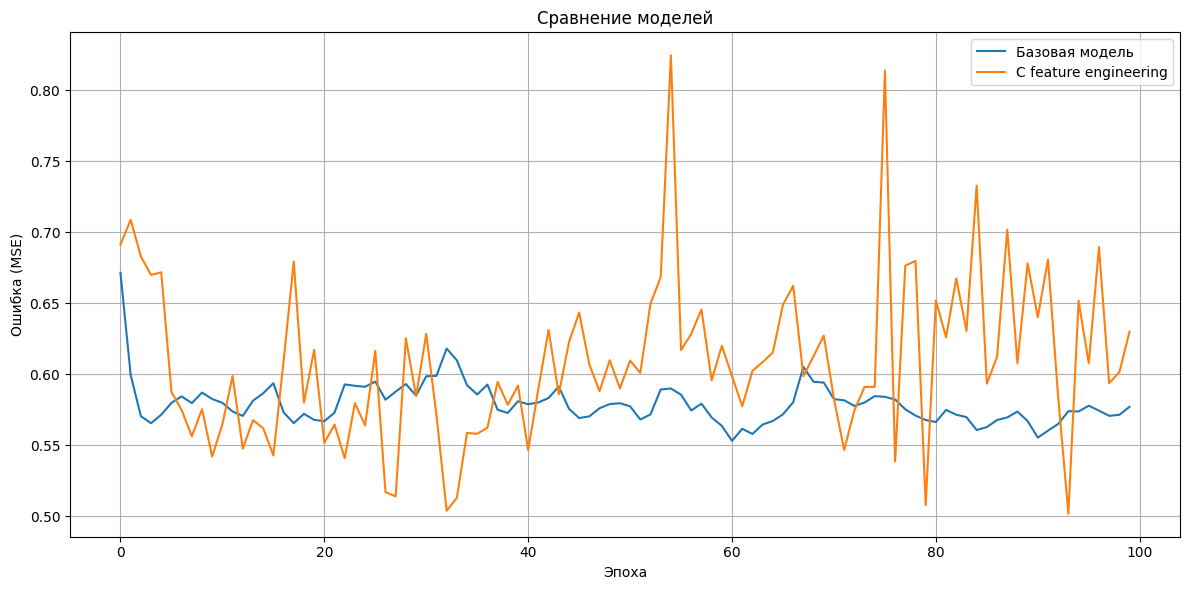


Итоговые результаты:
Базовая модель: Ошибка валидации = 0.5770
Модель с feature engineering: Ошибка валидации = 0.6300
Улучшение: -9.18%


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_diabetes
from models import LinearRegression

# Фиксация seed
torch.manual_seed(42)
np.random.seed(42)

class CSVDataset(Dataset):
    def __init__(self, file_path, target_column, 
                 numeric_features=None, 
                 categorical_features=None,
                 binary_features=None,
                 feature_engineering=False):
        # Загрузка данных
        self.df = pd.read_csv(file_path)
        self.feature_engineering = feature_engineering
        
        # Проверка наличия колонок
        self._validate_columns(target_column, numeric_features, 
                             categorical_features, binary_features)
        
        # Сохранение параметров
        self.target_column = target_column
        self.numeric_features = numeric_features or []
        self.categorical_features = categorical_features or []
        self.binary_features = binary_features or []
        
        # Предобработка данных
        self.preprocessor = self._create_preprocessor()
        self.X = self._preprocess_features()
        self.y = self._get_target()
        
    def _validate_columns(self, target_column, numeric_features, 
                         categorical_features, binary_features):
        # Проверка наличия всех указанных колонок в данных
        all_columns = (numeric_features or []) + \
                     (categorical_features or []) + \
                     (binary_features or []) + \
                     [target_column]
        
        missing = set(all_columns) - set(self.df.columns)
        if missing:
            raise ValueError(f"Отсутствуют колонки: {missing}")
    
    def _create_preprocessor(self):
        # Создание преобразователя для числовых признаков
        transformers = []
        
        if self.numeric_features:
            transformers.append(('num', StandardScaler(), self.numeric_features))
        if self.categorical_features:
            transformers.append(('cat', OneHotEncoder(sparse=False), self.categorical_features))
        if self.binary_features:
            transformers.append(('binary', 'passthrough', self.binary_features))
            
        return ColumnTransformer(transformers, remainder='drop')
    
    def _preprocess_features(self):
        # Применение предобработки и feature engineering
        X_processed = self.preprocessor.fit_transform(
            self.df.drop(columns=[self.target_column]))
        

        if self.feature_engineering:
            X_processed = self._apply_feature_engineering(X_processed)
        
        return torch.tensor(X_processed, dtype=torch.float32)
    
    def _apply_feature_engineering(self, X):
        # Полиномиальные признаки
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X)
        
        # Статистические признаки
        mean_features = np.mean(X, axis=1).reshape(-1, 1)
        var_features = np.var(X, axis=1).reshape(-1, 1)
        
        # Комбинируем все признаки
        X_extended = np.hstack((X_poly, mean_features, var_features))
        
        return X_extended
    
    def _get_target(self):
        # Преобразование целевой переменной в тензор
        y = self.df[self.target_column].values
        return torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    #Обучение с Валидацией

    train_losses = []
    val_losses = []
    
    for epoch in range(1, epochs + 1):
        # Обучение
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Валидация
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                epoch_val_loss += loss.item()
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Логирование каждые 10 эпох
        if epoch % 10 == 0 or epoch == epochs:
            print(f"Эпоха {epoch}/{epochs} | "
                  f"Ошибка обучения: {avg_train_loss:.4f} | "
                  f"Ошибка валидации: {avg_val_loss:.4f}")
    
    return train_losses, val_losses

def run_comparison():
    #Сравнение моделей
    csv_path = 'data/diabetes.csv'
    numeric_features = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
    
    # Создание базового датасета
    base_dataset = CSVDataset(
        file_path=csv_path,
        target_column='target',
        numeric_features=numeric_features,
        feature_engineering=False
    )
    
    # Создание расширенного датасета
    ext_dataset = CSVDataset(
        file_path=csv_path,
        target_column='target',
        numeric_features=numeric_features,
        feature_engineering=True
    )
    
    # Нормализация таргета
    target_scaler = TargetScaler()
    
    for dataset in [base_dataset, ext_dataset]:
        y = dataset.df['target'].values
        y_scaled = target_scaler.fit_transform(y)
        dataset.y = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)
    
    # Разделение данных на обучающую и валидационную выборки
    def split_dataset(dataset):
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        return random_split(dataset, [train_size, val_size])
    
    base_train, base_val = split_dataset(base_dataset)
    ext_train, ext_val = split_dataset(ext_dataset)
    
    batch_size = 32
    base_train_loader = DataLoader(base_train, batch_size=batch_size, shuffle=True)
    base_val_loader = DataLoader(base_val, batch_size=batch_size, shuffle=False)
    
    ext_train_loader = DataLoader(ext_train, batch_size=batch_size, shuffle=True)
    ext_val_loader = DataLoader(ext_val, batch_size=batch_size, shuffle=False)
    
    # Создание моделей
    base_model = LinearRegression(in_features=base_dataset.X.shape[1])
    ext_model = LinearRegression(in_features=ext_dataset.X.shape[1])
    
    criterion = nn.MSELoss()
    base_optimizer = optim.Adam(base_model.parameters(), lr=0.01)
    ext_optimizer = optim.Adam(ext_model.parameters(), lr=0.01)
    
    # Обучение базовой модели
    print("Обучение базовой модели...")
    _, base_val_losses = train_model(
        base_model, base_train_loader, base_val_loader, 
        criterion, base_optimizer, epochs=100
    )
    
    # Обучение модели с feature engineering
    print("\nОбучение модели с feature engineering...")
    _, ext_val_losses = train_model(
        ext_model, ext_train_loader, ext_val_loader, 
        criterion, ext_optimizer, epochs=100
    )
    
    # Визуализация результатов
    plt.figure(figsize=(12, 6))
    plt.plot(base_val_losses, label="Базовая модель")
    plt.plot(ext_val_losses, label="С feature engineering")
    plt.xlabel("Эпоха")
    plt.ylabel("Ошибка (MSE)")
    plt.title("Сравнение моделей")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plots/feature_engineering.png")
    plt.show()
    
    # Вывод итоговых результатов
    final_base_loss = base_val_losses[-1]
    final_ext_loss = ext_val_losses[-1]
    improvement = (final_base_loss - final_ext_loss) / final_base_loss * 100
    
    print(f"\nИтоговые результаты:")
    print(f"Базовая модель: Ошибка валидации = {final_base_loss:.4f}")
    print(f"Модель с feature engineering: Ошибка валидации = {final_ext_loss:.4f}")
    print(f"Улучшение: {improvement:.2f}%")

if __name__ == '__main__':
    import os
    os.makedirs("plots", exist_ok=True)
    run_comparison()

Базовая модель показала себя лучше